# Multi Sensitive Variable (OR sum rule)

## Introduction

**Main goal:** finding the **best model** for a **classification problem** (credit scoring problem in this case) according to **both** **predictive** a **fairness** **metrics**, considering a **multi sensitive variable**, defined by **OR** sum, based on **two individual sensitive variables**.

- `PyFairnessAI` can be used for this purpose.

A classic Machine Learning approach is used: Inner-Outer Evaluation. 

- **Inner**: selecting the best pipeline using k-fold cross-validation and hyper-parameter optimization.
- **Outer**: estimating best pipeline future performance through simple validation (train-test split)

- **Data**: German data. 
  
  - **Response/Target** variable: 'credit-risk' (values: 'good', 'bad' (candidate for the credit))
  
  - **Predictors**: 'checking_status', 'duration', 'credit_history', 'purpose',
       'credit_amount', 'savings_status', 'employment',
       'installment_commitment', 'other_parties', 'residence_since',
       'property_magnitude', 'age', 'other_payment_plans', 'housing',
       'existing_credits', 'job', 'num_dependents', 'own_telephone',
       'foreign_worker', 'sex', 'marital_status'

  - ***Two* sensitive variable (protected attribute)**: 'age', 'sex'.

    - **Privileged group**: 'age': >= 25 years (1); 'sex': male (1).
    - **Unprivileged group**: 'age': < 25 years (0); 'sex': female (0).

  - ***Multi* sensitive variable:** 'age_sex', defined by **OR** sum rule.
 
    - **Privileged group**: >= 25 years (1) OR  male (1)
    - **Unprivileged group**: < 25 years (0) AND female (0)

- **Pipelines** are used.

- **Base models**: 
  - Logistic Regression
  - XGBoost
  - LightGBoost
  - Random Forest

- **Base processors**:
  - Imputers
  - Encoders
  - Scalers


- **Fairness processors**: (*individual* and *combined*) 
  - **Pre**: Reweighing
  - **In**: Adversarial Debiasing, Exponentiated Gradient Reduction (ExpGR), Grid Search Reduction (GSR).
  - **Post**: Calibrated Equalized Odds (CEO), Reject Option Classifier (ROC).
  - **Pre + In**: Reweighing + ExpGR, Reweighing + GSR.
  - **Pre + Post**: Reweighing + CEO, Reweighing + ROC.
  - **Post + Pre**: CEO + Reweighing, ROC + Reweighing.
  - **Post + In**: CEO + ExpGR, ROC + ExpGR, CEO + GSR, ROC + GSR.


- **Fairness metric**: separation (avg odds error)

- **Predictive metric**: balanced accuracy



## Requirements

Necessary packages, function, classes and custom objects for running the code successfully. 

In [ ]:
import numpy as np
import pandas as pd
import os
import sys
import ast 
import argparse

import matplotlib.pyplot as plt
import seaborn as sns

from aif360.sklearn.datasets import fetch_german

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import tensorflow as tf

from PyMachineLearning.preprocessing import Encoder, Scaler, Imputer, ColumnTransformerToPandas
from PyMachineLearning.models import LogisticRegressionThreshold

from PyFairnessAI.model_selection import RandomizedSearchCVFairness, combined_score
from PyFairnessAI.preprocessing import ReweighingMetaEstimator
from PyFairnessAI.inprocessing import (AdversarialDebiasingEstimator, 
                                       ExponentiatedGradientReductionMetaEstimator, 
                                       GridSearchReductionMetaEstimator, Moment)
from PyFairnessAI.postprocessing import CalibratedEqualizedOdds, RejectOptionClassifier, PostProcessingMetaEstimator
from PyFairnessAI.metrics import average_odds_error

import time 

from itertools import chain

pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_key_preprocessing_grid(model, fairness_processors, preprocessing_grid):

    if any(x in model for x in fairness_processors['multi']): # Fairness multi processor involved in the model
        key1 = model + '__estimator' + '__estimator'
        key3 = None
        preprocessing_grid_ = preprocessing_grid['fairness_processor'].copy()
        if any(x in model for x in fairness_processors['pre_in']):
            key2 = model + '__estimator'
        elif any(x in model for x in fairness_processors['pre_post']):
            key2 = model + '__estimator' + '__postprocessor'
        elif any(x in model for x in fairness_processors['post_pre']):
            key2 = model + '__postprocessor'   
        elif any(x in model for x in fairness_processors['post_in']):
           key2 = model + '__estimator'
           key3 = model + '__postprocessor'   
    else:
        key2 = key3 = None
        if any(x in model for x in fairness_processors['pre'] + fairness_processors['in']): # Fairness pre or in processor involved in the model
            if model == 'adv_debiasing':
                key1 = model
            else:
                key1 = model + '__estimator' 
            preprocessing_grid_ = preprocessing_grid['fairness_processor'].copy()
        elif any(x in model for x in fairness_processors['post']): # Fairness post processor involved in the model
            key1 = model + '__estimator' 
            key2 = model + '__postprocessor'
            preprocessing_grid_ = preprocessing_grid['fairness_processor'].copy()       
        else: # No fairness processor involved
            key1 = model
            preprocessing_grid_ = preprocessing_grid['not_fairness_processor'].copy()
    
    return key1, key2, key3, preprocessing_grid_

###################################################################################################################

def get_model_param_grid(model, key):

    if 'log_reg' in model:

        param_grid = {f'{key}__penalty': ['l1', 'l2'],
                      f'{key}__C':  [0.01, 0.1, 1, 10, 30, 50, 75, 100],
                      f'{key}__class_weight': ['balanced', None],
                      f'{key}__threshold': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
                    }
    
    elif 'XGB' in model:

        param_grid = {f'{key}__max_depth': [10, 20, 30, 40, 50, 70, 100],
                      f'{key}__reg_lambda': np.arange(0, 1, 0.05),
                      f'{key}__n_estimators':  [30, 50, 70, 100],
                      f'{key}__eta': np.arange(0, 0.3, 0.02),
                      f'{key}__alpha': np.arange(0.2, 1, 0.01)
                    }

    elif 'LGB' in model:

        param_grid = {f'{key}__max_depth': np.arange(2, 50),
                      f'{key}__num_leaves':  np.arange(2, 50),
                      f'{key}__n_estimators': [30, 50, 70, 100, 120, 150],
                      f'{key}__learning_rate':  np.arange(0.001, 0.1, 0.003),
                      f'{key}__lambda_l1': np.arange(0.001, 1, 0.005),
                      f'{key}__lambda_l2': np.arange(0.001, 1, 0.005),
                      f'{key}__min_split_gain':  np.arange(0.001, 0.01, 0.001),
                      f'{key}__min_child_weight': np.arange(5, 50),
                      f'{key}__lambda_feature_fraction':  np.arange(0.1, 0.95, 0.05)                                                                                                           
                      }
    
    elif 'RF' in model:
        
        param_grid = {f'{key}__max_depth': np.arange(2, 15),
                      f'{key}__min_samples_leaf':  np.arange(2, 15),
                      f'{key}__min_samples_split':  np.arange(2, 15),
                      f'{key}__n_estimators': [30, 50, 70, 100, 120],
                      f'{key}__criterion': ['gini', 'entropy']                                                                                                 
                    }
        
    elif 'adv_debiasing' in model:
        
        param_grid = {f'{key}__adversary_loss_weight': np.arange(0.01, 1, 0.03),
                      f'{key}__num_epochs':  np.arange(10, 100),
                      f'{key}__batch_size':  np.arange(70, 200),
                      f'{key}__classifier_num_hidden_units': np.arange(70, 300),
                      f'{key}__debias': [True, False]   
                    }
        
    return param_grid

###################################################################################################################

def get_processor_param_grid(processor, key):

    if processor == 'expGR':

        param_grid = {f'{key}__constraints': ['DemographicParity', 'EqualizedOdds', 
                                              'TruePositiveRateParity', 'ErrorRateParity'],
                      f'{key}__eps': np.arange(0.001, 0.1, 0.003),
                      f'{key}__max_iter': np.arange(20, 100, 5),
                      f'{key}__eta0': np.arange(0.1, 4, 0.2),
                      f'{key}__drop_prot_attr': [True, False],
                    }   
        
    elif processor == 'GSR':

        param_grid = {f'{key}__constraints': ['DemographicParity', 'EqualizedOdds', 
                                              'TruePositiveRateParity', 'ErrorRateParity'],
                    f'{key}__constraint_weight': np.arange(0.01, 1, 0.05),
                    f'{key}__grid_size': np.arange(5, 50, 5),
                    f'{key}__grid_limit': np.arange(1, 10),
                    f'{key}__loss': ['ZeroOne', 'Square', 'Absolute'],                                
                    f'{key}__drop_prot_attr': [True, False],
                    }  
    
    elif processor == 'CEO':

        param_grid = {f'{key}__cost_constraint': ['fpr', 'fnr', 'weighted']}

    elif processor == 'ROC':

        param_grid = {f'{key}__threshold': np.arange(0.05, 0.5, 0.03), # must be between 0-0.5
                      f'{key}__margin': np.arange(0.01, 0.05, 0.005) # must be between 0-0.05
                    }
        
    return param_grid

###################################################################################################################

def get_pipeline_param_grid(model, fairness_processors, preprocessing_grid):

    key1, key2, key3, preprocessing_grid_ = get_key_preprocessing_grid(model, fairness_processors, preprocessing_grid)
    param_grid = preprocessing_grid_.copy()
    param_grid.update(get_model_param_grid(model, key=key1)) 
    
    if any(x in model for x in fairness_processors['multi']): # Multi processor involved

        if 'reweighing_' in model: 

            param_grid.update(get_processor_param_grid(processor=model.split('_')[-1], key=key2)) 
        
        elif '_reweighing' in model: 

            param_grid.update(get_processor_param_grid(processor=model.split('_')[-2], key=key2)) 

        else:

            param_grid.update(get_processor_param_grid(processor=model.split('_')[-1], key=key2))
            param_grid.update(get_processor_param_grid(processor=model.split('_')[-2], key=key3))

    else: # Not multi processor (no fairness processor or pre/in/post processor)
                
        if any(x in model for x in fairness_processors['in']): # in processor  
            if model != 'adv_debiasing':
                param_grid.update(get_processor_param_grid(processor=model.split('_')[-1], key=model))

        elif any(x in model for x in fairness_processors['post']): # post processor 

            param_grid.update(get_processor_param_grid(processor=model.split('_')[-1], key=key2))
    
    return param_grid

###################################################################################################################

def n_iter(model):

    if 'XGB' in model:
        return 1
    elif 'RF' in model:
        return 1
    else:
        return 1

In [3]:
sys.argv = ['notebook', '--sum_rule', 'OR'] # Use only in Jupyter Notebooks, not needed in Python scripts. 
# OR is being the assumed argument for the sum rule, that is, the rule for defining the multi sensitive variable.

# Argument parsing
parser = argparse.ArgumentParser(description='Process the sum_rule parameter.')
parser.add_argument('--sum_rule', choices=['AND', 'OR'], required=True, help='The sum rule to apply: AND or OR')
args = parser.parse_args()

## Preparing the data

Here we fetch an prepare the data properly to work with `PyFairnessAI`.

In [4]:
# Obtaining the data
X, y = fetch_german(binary_age=True)
# Defining the individual sensitive variables (protected attributes)
sens_variable_1 = 'age' # name of first sensitive variable
sens_variable_2 = 'sex' # name of second sensitive variable
# Encoding the sensitive variables
X[sens_variable_1] = X.apply(lambda row: 1 if row[sens_variable_1] >= 25 else 0, axis=1).astype('category')
encoder = Encoder(method='ordinal')
X[sens_variable_2] = encoder.fit_transform(X[sens_variable_2].to_numpy().reshape(-1, 1)).flatten().astype(int)
X[sens_variable_2] = X[sens_variable_2].astype('category')
# Defining the label of the privileged groups 
sens_1_priv_group = 1 # 1: >= 25 years, 0: < 25 years
sens_2_priv_group = 1 # 1: male, 0: female
# Encoding the response variable (needed for scikit-learn objects)
y = pd.Series(encoder.fit_transform(y.to_numpy().reshape(-1, 1)).flatten()) # good: 1 , bad: 0
# Defining the positive label of the response variable
response_favorable_label = 1 # 'good' before encoding

# Defining the multi sensitive variable based on the individual ones ('age', 'sex').
# Two possible sum rules are considered for defining the multi sens variable: AND, OR
# AND: the new privileged group is defined as the intersection of the privileged groups of the individual sens variables.
# OR: the new privileged group is defined as the union of the privileged groups of the individual sens variables.
sens_variable = 'age_sex'
if args.sum_rule == 'AND': 
    X[sens_variable] = X.apply(lambda row: 1 if row[sens_variable_1] == sens_1_priv_group and row[sens_variable_2] == sens_2_priv_group else 0, axis=1)
elif args.sum_rule == 'OR':
    X[sens_variable] = X.apply(lambda row: 1 if row[sens_variable_1] == sens_1_priv_group or row[sens_variable_2] == sens_2_priv_group else 0, axis=1)

# Defining the privileged group of the new  (multi) sensitive variable 
sens_priv_group = 1 # 1 (priv group): '>= 25' years AND/OR 'male', 0 (unpriv group): otherwise ('< 25' years OR/AND 'female')
X[sens_variable] = X[sens_variable].astype('category') # necessary to work properly with some aif360 objects

# Removing the individual sensitive variables 
X = X.drop([sens_variable_1, sens_variable_2], axis=1)

# Indexing with the sens_variable is needed for fairness post-processing
X.index = X[sens_variable] 
y.index = X[sens_variable]  
# A is needed for some fairness metric objects
A = X[sens_variable]

In [5]:
X.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,other_parties,residence_since,property_magnitude,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,marital_status,age_sex
age_sex,,,,,,,,,,,,,,,,,,,,
1,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,none,4,real estate,none,own,2,skilled,1,yes,yes,single,1
0,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,none,2,real estate,none,own,1,skilled,1,none,yes,div/dep/mar,0
1,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,none,3,real estate,none,own,1,unskilled resident,2,none,yes,single,1
1,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,guarantor,4,life insurance,none,for free,1,skilled,2,none,yes,single,1
1,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,none,4,no known property,none,for free,2,skilled,2,none,yes,single,1


In [6]:
X.shape

(1000, 20)

In [7]:
y.head()

age_sex
1    1.0
0    0.0
1    1.0
1    1.0
1    0.0
dtype: float64

In [8]:
y.shape

(1000,)

In [9]:
# Collecting the quant and categorical predictors, as well as all the predictors.
quant_predictors = [col for col in X.columns if X.dtypes[col] != 'category']
cat_predictors = [col for col in X.columns if col not in quant_predictors]  
predictors = quant_predictors + cat_predictors # X.columns

In [10]:
quant_predictors

['duration',
 'credit_amount',
 'installment_commitment',
 'residence_since',
 'existing_credits',
 'num_dependents']

In [11]:
cat_predictors

['checking_status',
 'credit_history',
 'purpose',
 'savings_status',
 'employment',
 'other_parties',
 'property_magnitude',
 'other_payment_plans',
 'housing',
 'job',
 'own_telephone',
 'foreign_worker',
 'marital_status',
 'age_sex']

### Outer evaluation method

Defining the outer evaluation method: simple validation (train-test split), stratified by the response variable.

In [12]:
random_state = 123
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(X, y, A, train_size=0.85, random_state=random_state, stratify=y)
# A_test is needed for outer evaluation (estimation of future performance) with respect to fairness 

### Inner evaluation method

Defining the inner evaluation method: stratified k-Fold Cross-Validation

In [13]:
inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

### Defining pipelines

Defining the pipelines, which encompasses base processors, fairness processors and base models.

In [ ]:
models, pipelines, fairness_processors, preprocessing_grid = {}, {}, {}, {}

quant_pipeline = Pipeline([
    ('imputer', Imputer()),
    ('scaler', Scaler())
    ])

cat_pipeline = Pipeline([
    ('imputer', Imputer(method='simple_most_frequent')),
    ('encoder', Encoder(method='one-hot', drop='first'))
    ])

quant_cat_processing = ColumnTransformer(transformers=[('quant', quant_pipeline, quant_predictors),
                                                       ('cat', cat_pipeline, cat_predictors)])


# Set up TensorFlow session (required by AdversarialDebiasingEstimator)
tf_session = tf.compat.v1.Session
# disable_eager_execution is required as well by TensorFlow
tf.compat.v1.disable_eager_execution()
tf.random.set_seed(random_state)

ceo = CalibratedEqualizedOdds(prot_attr=sens_variable, random_state=random_state) # Fairnes post-processor
roc = RejectOptionClassifier(prot_attr=sens_variable) # Fairnes post-processor

models['log_reg'] = LogisticRegressionThreshold(solver='liblinear', random_state=random_state)
models['XGB'] = XGBClassifier(random_state=random_state)
models['LGB'] = LGBMClassifier(random_state=random_state)
models['RF'] = RandomForestClassifier(random_state=random_state)

models['log_reg_reweighing'] = ReweighingMetaEstimator(estimator=models['log_reg'], prot_attr=sens_variable) # Fairness Pre-Processor
models['XGB_reweighing'] = ReweighingMetaEstimator(estimator=models['XGB'], prot_attr=sens_variable) # Fairness Pre-Processor
models['LGB_reweighing'] = ReweighingMetaEstimator(estimator=models['LGB'], prot_attr=sens_variable) # Fairness Pre-Processor
models['RF_reweighing'] = ReweighingMetaEstimator(estimator=models['RF'], prot_attr=sens_variable) # Fairness Pre-Processor

models['adv_debiasing'] = AdversarialDebiasingEstimator(prot_attr=sens_variable, scope_name='classifier', random_state=random_state) # Fairness In-Processor

models['log_reg_expGR'] = ExponentiatedGradientReductionMetaEstimator(prot_attr=sens_variable, estimator=models['log_reg']) # Fairness In-Processor
models['XGB_expGR'] = ExponentiatedGradientReductionMetaEstimator(prot_attr=sens_variable, estimator=models['XGB']) # Fairness In-Processor
models['LGB_expGR'] = ExponentiatedGradientReductionMetaEstimator(prot_attr=sens_variable, estimator=models['LGB']) # Fairness In-Processor
models['RF_expGR'] = ExponentiatedGradientReductionMetaEstimator(prot_attr=sens_variable, estimator=models['RF']) # Fairness In-Processor
models['log_reg_GSR'] = GridSearchReductionMetaEstimator(prot_attr=sens_variable, estimator=models['log_reg']) # Fairness In-Processor
models['XGB_GSR'] = GridSearchReductionMetaEstimator(prot_attr=sens_variable, estimator=models['XGB']) # Fairness In-Processor
models['LGB_GSR'] = GridSearchReductionMetaEstimator(prot_attr=sens_variable, estimator=models['LGB']) # Fairness In-Processor
models['RF_GSR'] = GridSearchReductionMetaEstimator(prot_attr=sens_variable, estimator=models['RF']) # Fairness In-Processor

models['log_reg_CEO'] = PostProcessingMetaEstimator(estimator=models['log_reg'], postprocessor=ceo, prefit=False, val_size=0.25) # Fairnes post-processor
models['XGB_CEO'] = PostProcessingMetaEstimator(estimator=models['XGB'], postprocessor=ceo, prefit=False, val_size=0.25) # Fairnes post-processor
models['LGB_CEO'] = PostProcessingMetaEstimator(estimator=models['LGB'], postprocessor=ceo, prefit=False, val_size=0.25) # Fairnes post-processor
models['RF_CEO'] = PostProcessingMetaEstimator(estimator=models['RF'], postprocessor=ceo, prefit=False, val_size=0.25) # Fairnes post-processor

models['log_reg_ROC'] = PostProcessingMetaEstimator(estimator=models['log_reg'], postprocessor=roc, prefit=False, val_size=0.25) # Fairnes post-processor
models['XGB_ROC'] = PostProcessingMetaEstimator(estimator=models['XGB'], postprocessor=roc, prefit=False, val_size=0.25) # Fairnes post-processor
models['LGB_ROC'] = PostProcessingMetaEstimator(estimator=models['LGB'], postprocessor=roc, prefit=False, val_size=0.25) # Fairnes post-processor
models['RF_ROC'] = PostProcessingMetaEstimator(estimator=models['RF'], postprocessor=roc, prefit=False, val_size=0.25) # Fairnes post-processor

models['log_reg_reweighing_expGR'] = ReweighingMetaEstimator(estimator=models['log_reg_expGR'], prot_attr=sens_variable) # pre + in
models['XGB_reweighing_expGR'] = ReweighingMetaEstimator(estimator=models['XGB_expGR'], prot_attr=sens_variable) # pre + in
models['LGB_reweighing_expGR'] = ReweighingMetaEstimator(estimator=models['LGB_expGR'], prot_attr=sens_variable) # pre + in
models['RF_reweighing_expGR'] = ReweighingMetaEstimator(estimator=models['RF_expGR'], prot_attr=sens_variable) # pre + in

models['log_reg_reweighing_GSR'] = ReweighingMetaEstimator(estimator=models['log_reg_GSR'], prot_attr=sens_variable) # pre + in
models['XGB_reweighing_GSR'] = ReweighingMetaEstimator(estimator=models['XGB_GSR'], prot_attr=sens_variable) # pre + in
models['LGB_reweighing_GSR'] = ReweighingMetaEstimator(estimator=models['LGB_GSR'], prot_attr=sens_variable) # pre + in
models['RF_reweighing_GSR'] = ReweighingMetaEstimator(estimator=models['RF_GSR'], prot_attr=sens_variable) # pre + in

models['log_reg_reweighing_CEO'] = ReweighingMetaEstimator(estimator=models['log_reg_CEO'], prot_attr=sens_variable) # pre + post
models['XGB_reweighing_CEO'] = ReweighingMetaEstimator(estimator=models['XGB_CEO'], prot_attr=sens_variable) # pre + post
models['LGB_reweighing_CEO'] = ReweighingMetaEstimator(estimator=models['LGB_CEO'], prot_attr=sens_variable) # pre + post
models['RF_reweighing_CEO'] = ReweighingMetaEstimator(estimator=models['RF_CEO'], prot_attr=sens_variable) # pre + post

models['log_reg_reweighing_ROC'] = ReweighingMetaEstimator(estimator=models['log_reg_ROC'], prot_attr=sens_variable) # pre + post
models['XGB_reweighing_ROC'] = ReweighingMetaEstimator(estimator=models['XGB_ROC'], prot_attr=sens_variable) # pre + post
models['LGB_reweighing_ROC'] = ReweighingMetaEstimator(estimator=models['LGB_ROC'], prot_attr=sens_variable) # pre + post
models['RF_reweighing_ROC'] = ReweighingMetaEstimator(estimator=models['RF_ROC'], prot_attr=sens_variable) # pre + post

models['log_reg_CEO_reweighing'] = PostProcessingMetaEstimator(estimator=models['log_reg_reweighing'], postprocessor=ceo, prefit=False, val_size=0.25)  # post + pre
models['XGB_CEO_reweighing'] = PostProcessingMetaEstimator(estimator=models['XGB_reweighing'], postprocessor=ceo, prefit=False, val_size=0.25)  # post + pre
models['LGB_CEO_reweighing'] = PostProcessingMetaEstimator(estimator=models['LGB_reweighing'], postprocessor=ceo, prefit=False, val_size=0.25)  # post + pre
models['RF_CEO_reweighing'] = PostProcessingMetaEstimator(estimator=models['RF_reweighing'], postprocessor=ceo, prefit=False, val_size=0.25)  # post + pre

models['log_reg_ROC_reweighing'] = PostProcessingMetaEstimator(estimator=models['log_reg_reweighing'], postprocessor=roc, prefit=False, val_size=0.25)  # post + pre
models['XGB_ROC_reweighing'] = PostProcessingMetaEstimator(estimator=models['XGB_reweighing'], postprocessor=roc, prefit=False, val_size=0.25)  # post + pre
models['LGB_ROC_reweighing'] = PostProcessingMetaEstimator(estimator=models['LGB_reweighing'], postprocessor=roc, prefit=False, val_size=0.25)  # post + pre
models['RF_ROC_reweighing'] = PostProcessingMetaEstimator(estimator=models['RF_reweighing'], postprocessor=roc, prefit=False, val_size=0.25)  # post + pre

models['log_reg_CEO_expGR'] = PostProcessingMetaEstimator(estimator=models['log_reg_expGR'], postprocessor=ceo, prefit=False, val_size=0.25)  # post + in
models['XGB_CEO_expGR'] = PostProcessingMetaEstimator(estimator=models['XGB_expGR'], postprocessor=ceo, prefit=False, val_size=0.25)  # post + in
models['LGB_CEO_expGR'] = PostProcessingMetaEstimator(estimator=models['LGB_expGR'], postprocessor=ceo, prefit=False, val_size=0.25)  # post + in
models['RF_CEO_expGR'] = PostProcessingMetaEstimator(estimator=models['RF_expGR'], postprocessor=ceo, prefit=False, val_size=0.25)  # post + in

models['log_reg_ROC_expGR'] = PostProcessingMetaEstimator(estimator=models['log_reg_expGR'], postprocessor=roc, prefit=False, val_size=0.25)  # post + in
models['XGB_ROC_expGR'] = PostProcessingMetaEstimator(estimator=models['XGB_expGR'], postprocessor=roc, prefit=False, val_size=0.25)  # post + in
models['LGB_ROC_expGR'] = PostProcessingMetaEstimator(estimator=models['LGB_expGR'], postprocessor=roc, prefit=False, val_size=0.25)  # post + in
models['RF_ROC_expGR'] = PostProcessingMetaEstimator(estimator=models['RF_expGR'], postprocessor=roc, prefit=False, val_size=0.25)  # post + in

models['log_reg_CEO_GSR'] = PostProcessingMetaEstimator(estimator=models['log_reg_GSR'], postprocessor=ceo, prefit=False, val_size=0.25)  # post + in
models['XGB_CEO_GSR'] = PostProcessingMetaEstimator(estimator=models['XGB_GSR'], postprocessor=ceo, prefit=False, val_size=0.25)  # post + in
models['LGB_CEO_GSR'] = PostProcessingMetaEstimator(estimator=models['LGB_GSR'], postprocessor=ceo, prefit=False, val_size=0.25)  # post + in
models['RF_CEO_GSR'] = PostProcessingMetaEstimator(estimator=models['RF_GSR'], postprocessor=ceo, prefit=False, val_size=0.25)  # post + in

models['log_reg_ROC_GSR'] = PostProcessingMetaEstimator(estimator=models['log_reg_GSR'], postprocessor=roc, prefit=False, val_size=0.25)  # post + in
models['XGB_ROC_GSR'] = PostProcessingMetaEstimator(estimator=models['XGB_GSR'], postprocessor=roc, prefit=False, val_size=0.25)  # post + in
models['LGB_ROC_GSR'] = PostProcessingMetaEstimator(estimator=models['LGB_GSR'], postprocessor=roc, prefit=False, val_size=0.25)  # post + in
models['RF_ROC_GSR'] = PostProcessingMetaEstimator(estimator=models['RF_GSR'], postprocessor=roc, prefit=False, val_size=0.25)  # post + in

fairness_processors['pre'] = ['reweighing']
fairness_processors['in'] = ['expGR', 'GSR', 'adv_debiasing'] 
fairness_processors['post'] = ['CEO', 'ROC']
fairness_processors['pre_in'] = ['reweighing_expGR', 'reweighing_GSR']
fairness_processors['pre_post'] = ['reweighing_CEO', 'reweighing_ROC']
fairness_processors['post_pre'] = ['CEO_reweighing', 'ROC_reweighing']
fairness_processors['post_in'] = ['CEO_expGR', 'ROC_expGR', 'CEO_GSR', 'ROC_GSR']
fairness_processors['multi'] = fairness_processors['pre_in'] + fairness_processors['pre_post'] + fairness_processors['post_pre'] + fairness_processors['post_in']
fairness_processors['all'] = list(chain(*[fairness_processors[x] for x in fairness_processors.keys()]))

for key, model in models.items():

    if  any(x in key for x in fairness_processors['all']): # model[key] involves fairness processor

        pipelines[key] = Pipeline([
                # Fairness processors need a Pandas df X as input to read the sens_variable_name
                ('preprocessing', ColumnTransformerToPandas(column_transformer=quant_cat_processing,
                                                            prot_attr=sens_variable,  
                                                            prot_attr_index=True)), # prot_attr_index=True needed for fairness post-processors
                (key, model) 
                ])            

    else: # model[key] does not involve fairness processor

        pipelines[key] = Pipeline([
                ('preprocessing', quant_cat_processing),
                (key, model) 
                ])

### Defining grids

Defining the grids for the parameters of each pipeline to be explored in the hyper-parameter optimization (HPO) part.

In [15]:
preprocessing_grid['not_fairness_processor'] = {'preprocessing__quant__scaler__apply': [True, False],
                                                'preprocessing__quant__scaler__method': ['standard', 'min-max'],
                                                'preprocessing__cat__encoder__method': ['ordinal', 'one-hot'],
                                                'preprocessing__cat__imputer__apply':  [False],
                                                'preprocessing__quant__imputer__apply': [False],
                                               #'preprocessing__cat__imputer__method':  ['simple_most_frequent'],
                                               #'preprocessing__quant__imputer__method': ['simple_mean', 'simple_median']
                                                }

# Same as  preprocessing_grid['not_fairness_preprocessor'] but adding '__column_transformer__' to the keys (needed in ColumnTransformerToPandas)        
preprocessing_grid['fairness_processor'] = {'__'.join([k.split('__')[0]] + ['column_transformer'] + k.split('__')[1:]) : v 
                                            for k, v in preprocessing_grid['not_fairness_processor'].items()}

In [16]:
param_grid = {}
for model in pipelines.keys():
    param_grid[model] = get_pipeline_param_grid(model, fairness_processors, preprocessing_grid)

## Applying inner evaluation

- Finding the best model based on fairness and predictive metrics.

The idea is to apply the combined score in two steps/stages:

1) For optimizing the hyper-parameters of each model and obtaining their best version according to both predictive power and fairness degree.

2) For selecting the final best model according to both predictive power and fairness degree.

In this first step we apply HPO on all the defined pipelines, looking for the best trade-off between predictive power and fairness as objective of the optimization process.

After this steps we will have the best version of each alternative (pipeline).

In [ ]:
best_results_list = []

for model in pipelines.keys():

    fairness_random_search = RandomizedSearchCVFairness(estimator=pipelines[model], 
                                                        param_distributions=param_grid[model], 
                                                        fairness_scoring='average_odds_error', 
                                                        predictive_scoring='balanced_accuracy',
                                                        objective='combined', 
                                                        fairness_scoring_direction='minimize',
                                                        predictive_scoring_direction='maximize',
                                                        fairness_weight=0.5, predictive_weight=0.5,
                                                        cv=inner, n_iter=n_iter(model), 
                                                        random_state=random_state,
                                                        prot_attr=sens_variable, 
                                                        priv_group=sens_priv_group,
                                                        pos_label=response_favorable_label)

    start_time = time.time()
    fairness_random_search.fit(X=X_train, y=y_train)
    end_time = time.time()
    elapsed_time = np.round(end_time - start_time, 3)
    best_result_dict = {'model': model, 'time': elapsed_time}
    best_result_dict.update(dict(fairness_random_search.cv_results_.iloc[0]))
    best_results_list.append(best_result_dict)

Once the best results for each pipeline are collected, the second step is to apply the combined score again, but this time on these best results, so that we will be able to select the best final alternative (pipeline) in terms of both fairness and prediction.

In [54]:
best_results = pd.DataFrame(best_results_list)
best_results['combined-score'] = combined_score(predictive_scores=best_results['predictive-score'], 
                                                fairness_scores=best_results['fairness-score'], 
                                                predictive_scoring_direction='maximize', 
                                                fairness_scoring_direction='minimize',
                                                predictive_weight=0.5, fairness_weight=0.5)
best_results = best_results.sort_values(by='combined-score', ascending=False)

Now the final results are saved as a .csv file.

In [ ]:
file_name = f'best_results_fairness_workflow_multisens_{args.sum_rule}'
results_path = rf'C:\Users\fscielzo\Documents\IBiDat\Fairness AI\PyFairnessAI-package\notebooks\Project-notebooks\results\{file_name}.csv'

# Check if the file already exists
if not os.path.exists(results_path):
    # If the file doesn't exist, save the CSV
    best_results.to_csv(results_path)
    print(f"File saved at: {results_path}")
else:
    print(f"File already exists at: {results_path}")

### Inner results  

In this section the inner results (the ones collected above) will be analyzed.

We read the results saved as a .csv file. This file contains, for each tested pipeline, information regarding the its name (`model`), its execution in the inner evaluation (`time`), its optimized parameters resulting of HPO process (`params`) and, finally, its predictive, fairness and combined score (`predictive-score`, `fairness-score`, `combined-score`).

In [2]:
file_name = f'best_results_fairness_workflow_multisens_OR'
results_path = rf'C:\Users\fscielzo\Documents\IBiDat\Fairness AI\PyFairnessAI-package\notebooks\Project-notebooks\results\{file_name}_v3.csv'
best_results = pd.read_csv(results_path, index_col=0)

The top three results are displayed in the following table:

In [3]:
best_results.head(3)

,model,time,params,predictive-score,fairness-score,combined-score
4,log_reg_reweighing,13.116,"{'preprocessing__column_transformer__quant__scaler__apply': False, 'preprocessing__column_transformer__quant__scaler__method': 'min-max', 'preprocessing__column_transformer__cat__encoder__method': 'one-hot', 'preprocessing__column_transformer__cat__imputer__apply': False, 'preprocessing__column_transformer__quant__imputer__apply': False, 'log_reg_reweighing__estimator__penalty': 'l1', 'log_reg_reweighing__estimator__C': 50, 'log_reg_reweighing__estimator__class_weight': 'balanced', 'log_reg_reweighing__estimator__threshold': 0.7}",0.708571,0.144002,0.833953
25,log_reg_reweighing_expGR,204.948,"{'preprocessing__column_transformer__quant__scaler__apply': False, 'preprocessing__column_transformer__quant__scaler__method': 'min-max', 'preprocessing__column_transformer__cat__encoder__method': 'ordinal', 'preprocessing__column_transformer__cat__imputer__apply': False, 'preprocessing__column_transformer__quant__imputer__apply': False, 'log_reg_reweighing_expGR__estimator__estimator__penalty': 'l1', 'log_reg_reweighing_expGR__estimator__estimator__C': 1, 'log_reg_reweighing_expGR__estimator__estimator__class_weight': 'balanced', 'log_reg_reweighing_expGR__estimator__estimator__threshold': 0.6, 'log_reg_reweighing_expGR__estimator__constraints': 'TruePositiveRateParity', 'log_reg_reweighing_expGR__estimator__eps': 0.097, 'log_reg_reweighing_expGR__estimator__max_iter': 85, 'log_reg_reweighing_expGR__estimator__eta0': 1.7000000000000004, 'log_reg_reweighing_expGR__estimator__drop_prot_attr': False}",0.687937,0.121635,0.804608
9,log_reg_expGR,230.075,"{'preprocessing__column_transformer__quant__scaler__apply': False, 'preprocessing__column_transformer__quant__scaler__method': 'min-max', 'preprocessing__column_transformer__cat__encoder__method': 'ordinal', 'preprocessing__column_transformer__cat__imputer__apply': False, 'preprocessing__column_transformer__quant__imputer__apply': False, 'log_reg_expGR__estimator__penalty': 'l1', 'log_reg_expGR__estimator__C': 1, 'log_reg_expGR__estimator__class_weight': 'balanced', 'log_reg_expGR__estimator__threshold': 0.6, 'log_reg_expGR__constraints': 'TruePositiveRateParity', 'log_reg_expGR__eps': 0.097, 'log_reg_expGR__max_iter': 85, 'log_reg_expGR__eta0': 1.7000000000000004, 'log_reg_expGR__drop_prot_attr': False}",0.693333,0.147256,0.785120


The worst three results are displayed in the following table:

In [4]:
best_results.tail(3)

,model,time,params,predictive-score,fairness-score,combined-score
50,XGB_CEO_expGR,624.871,"{'preprocessing__column_transformer__quant__scaler__apply': False, 'preprocessing__column_transformer__quant__scaler__method': 'min-max', 'preprocessing__column_transformer__cat__encoder__method': 'ordinal', 'preprocessing__column_transformer__cat__imputer__apply': False, 'preprocessing__column_transformer__quant__imputer__apply': False, 'XGB_CEO_expGR__estimator__estimator__max_depth': 20, 'XGB_CEO_expGR__estimator__estimator__reg_lambda': 0.8500000000000001, 'XGB_CEO_expGR__estimator__estimator__n_estimators': 100, 'XGB_CEO_expGR__estimator__estimator__eta': 0.12, 'XGB_CEO_expGR__estimator__estimator__alpha': 0.7900000000000005, 'XGB_CEO_expGR__estimator__constraints': 'DemographicParity', 'XGB_CEO_expGR__estimator__eps': 0.001, 'XGB_CEO_expGR__estimator__max_iter': 40, 'XGB_CEO_expGR__estimator__eta0': 2.900000000000001, 'XGB_CEO_expGR__estimator__drop_prot_attr': True, 'XGB_CEO_expGR__postprocessor__cost_constraint': 'fpr'}",0.635556,0.302239,0.403983
18,XGB_CEO,8.580,"{'preprocessing__column_transformer__quant__scaler__apply': True, 'preprocessing__column_transformer__quant__scaler__method': 'min-max', 'preprocessing__column_transformer__cat__encoder__method': 'ordinal', 'preprocessing__column_transformer__cat__imputer__apply': False, 'preprocessing__column_transformer__quant__imputer__apply': False, 'XGB_CEO__estimator__max_depth': 40, 'XGB_CEO__estimator__reg_lambda': 0.8500000000000001, 'XGB_CEO__estimator__n_estimators': 30, 'XGB_CEO__estimator__eta': 0.2, 'XGB_CEO__estimator__alpha': 0.5600000000000003, 'XGB_CEO__postprocessor__cost_constraint': 'fnr'}",0.614603,0.371927,0.247243
42,XGB_CEO_reweighing,7.711,"{'preprocessing__column_transformer__quant__scaler__apply': True, 'preprocessing__column_transformer__quant__scaler__method': 'min-max', 'preprocessing__column_transformer__cat__encoder__method': 'ordinal', 'preprocessing__column_transformer__cat__imputer__apply': False, 'preprocessing__column_transformer__quant__imputer__apply': False, 'XGB_CEO_reweighing__estimator__estimator__max_depth': 70, 'XGB_CEO_reweighing__estimator__estimator__reg_lambda': 0.7000000000000001, 'XGB_CEO_reweighing__estimator__estimator__n_estimators': 30, 'XGB_CEO_reweighing__estimator__estimator__eta': 0.28, 'XGB_CEO_reweighing__estimator__estimator__alpha': 0.25000000000000006, 'XGB_CEO_reweighing__postprocessor__cost_constraint': 'fpr'}",0.603175,0.401873,0.172828


### Best pipeline selection 

In this section the best alternative (pipeline) over all, in terms of both fairness and predictive power,  will be selected.

For illustration and interpretation purposes, several ranking plots will be displayed.

In [20]:
n_top = 10
n_worst = 10
scores = ['combined-score', 'predictive-score', 'fairness-score']
top_pipelines = best_results['model'].head(n_top).to_list()
worst_pipelines = best_results['model'].tail(n_worst).to_list()

top_scores, worst_scores = {}, {}
for score in scores: 
    top_scores[score] = best_results[score].head(n_top).to_list()
    worst_scores[score] = best_results[score].tail(n_worst).to_list()

best_pipeline = best_results['model'].head(1).iloc[0]
worst_pipeline = best_results['model'].tail(1).iloc[0]
best_score, worst_score = {}, {}
for score in scores:
    best_score[score] = best_results[score].head(1).iloc[0]
    worst_score[score] = best_results[score].tail(1).iloc[0]

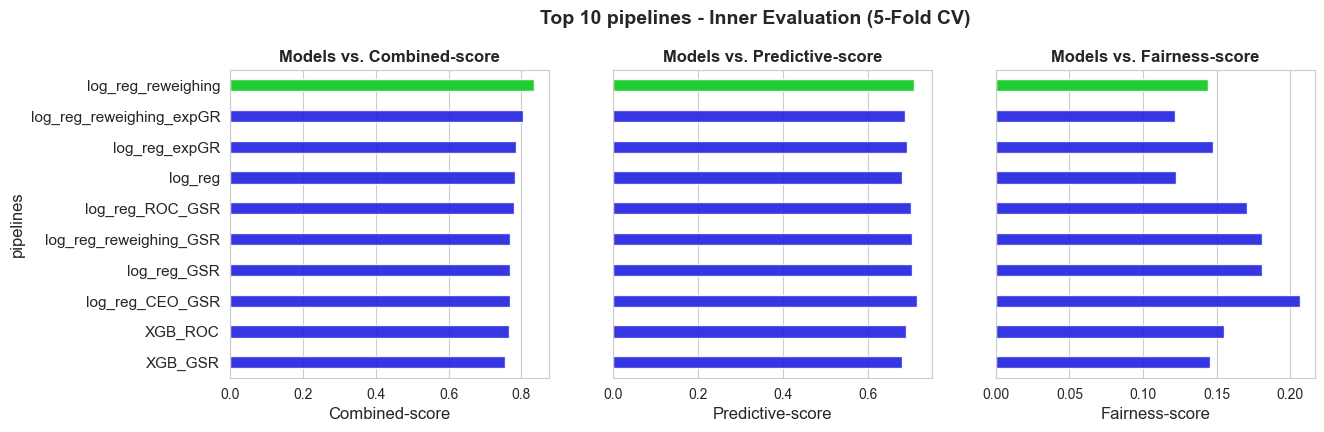

In [21]:
fig, axes = plt.subplots(1,3, figsize=(14,4))
axes = axes.flatten()

for i, score in enumerate(scores):
    ax = sns.barplot(y=top_pipelines, x=top_scores[score], color='blue', width=0.4, alpha=0.9, ax=axes[i])
    ax = sns.barplot(y=[best_pipeline], x=[best_score[score]], color='lime', width=0.4, alpha=0.9, ax=axes[i])
    axes[i].set_title(f'Models vs. {score.capitalize()}', size=12, weight='bold')
    axes[i].set_xlabel(score.capitalize(), size=12)
    
    if i == 0:
        axes[i].set_ylabel('pipelines', size=12)
        axes[i].tick_params(axis='y', labelsize=11)    

    else:
        axes[i].set_yticklabels([])

plt.suptitle(f'Top {n_top} pipelines - Inner Evaluation (5-Fold CV)', fontsize=14, weight='bold', y=1.03)

plt.show()

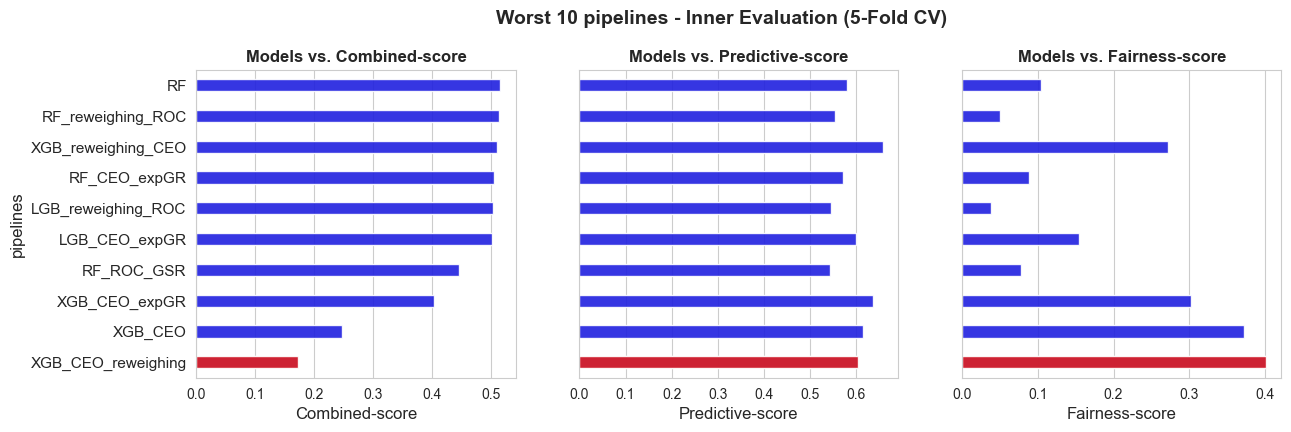

In [22]:
fig, axes = plt.subplots(1,3, figsize=(14,4))
axes = axes.flatten()

for i, score in enumerate(scores):
    ax = sns.barplot(y=worst_pipelines, x=worst_scores[score], color='blue', width=0.4, alpha=0.9, ax=axes[i])
    ax = sns.barplot(y=[worst_pipeline], x=[worst_score[score]], color='red', width=0.4, alpha=0.9, ax=axes[i])
    axes[i].set_title(f'Models vs. {score.capitalize()}', size=12, weight='bold')
    axes[i].set_xlabel(score.capitalize(), size=12)
    
    if i == 0:
        axes[i].set_ylabel('pipelines', size=12)
        axes[i].tick_params(axis='y', labelsize=11)    

    else:
        axes[i].set_yticklabels([])

plt.suptitle(f'Worst {n_worst} pipelines - Inner Evaluation (5-Fold CV)', fontsize=14, weight='bold', y=1.03)

plt.show()

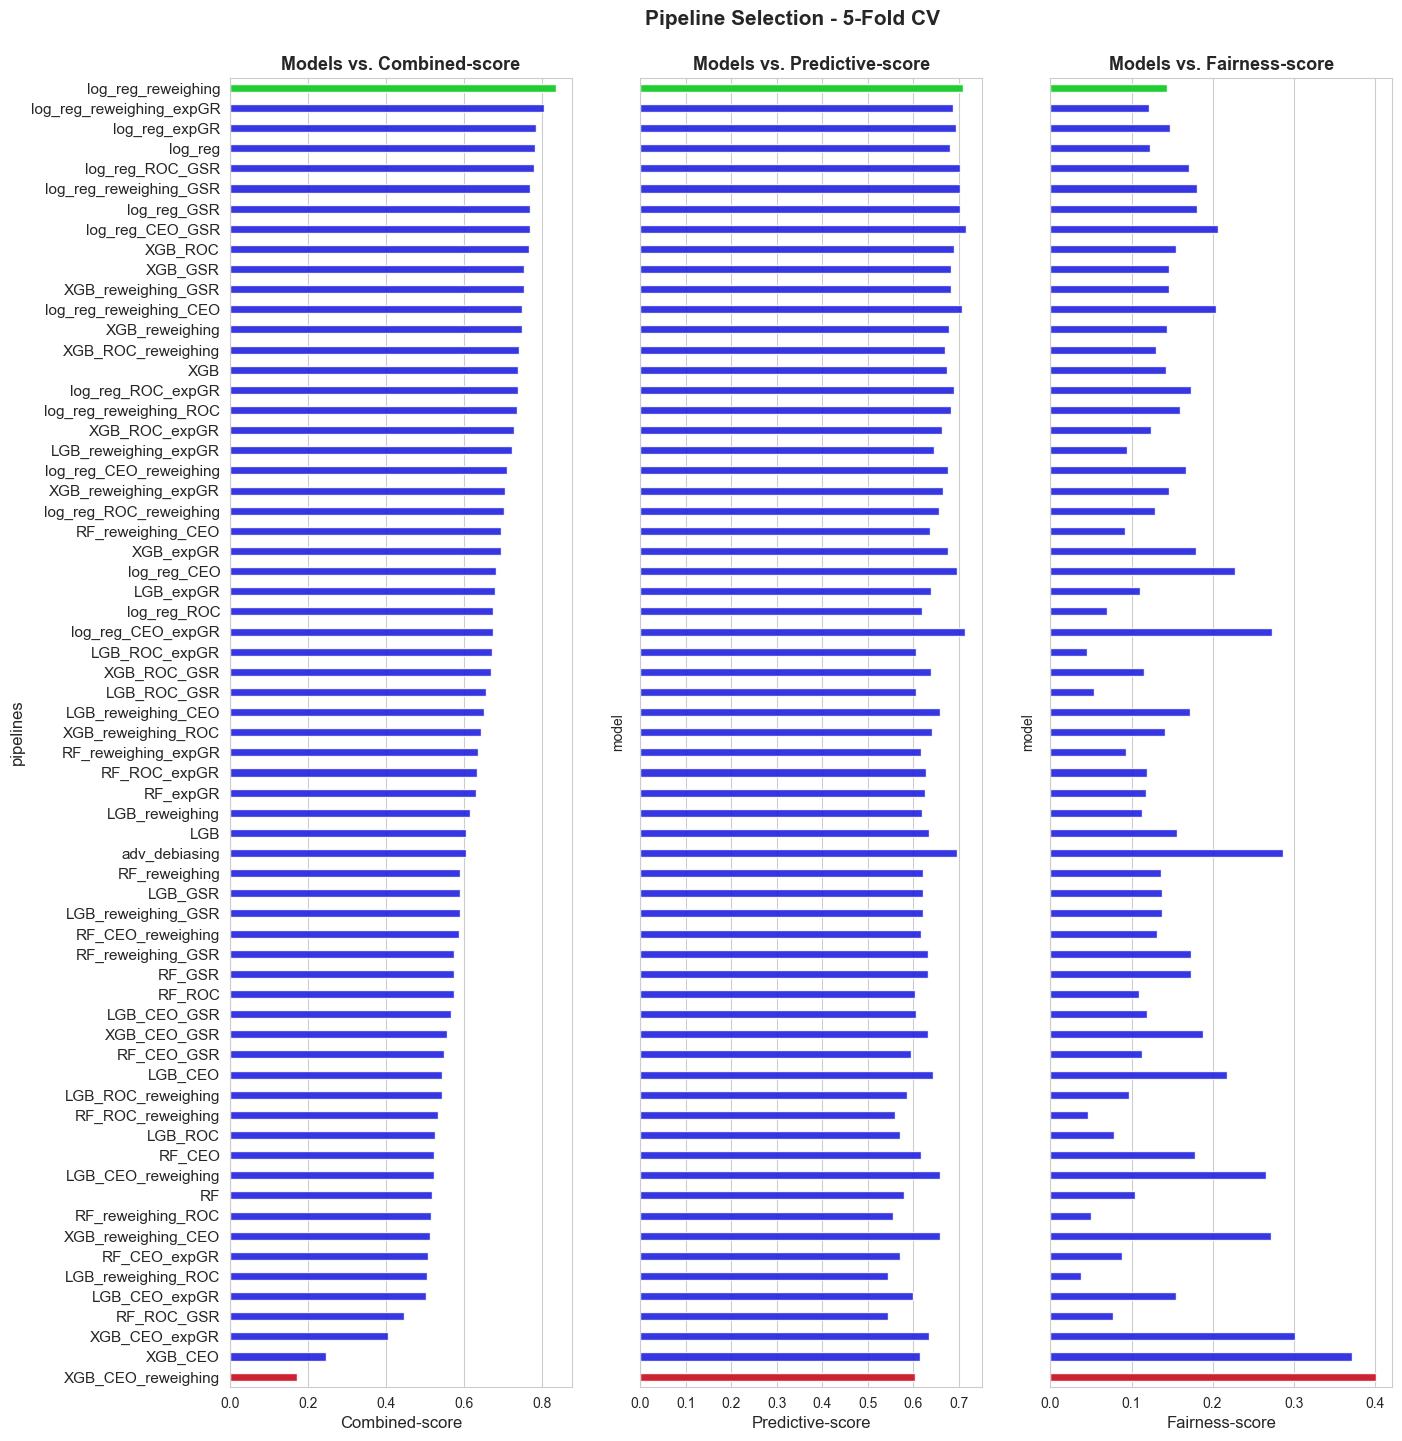

In [23]:
fig, axes = plt.subplots(1,3, figsize=(15,17))
axes = axes.flatten()

for i, score in enumerate(scores):
    ax = sns.barplot(y=best_results['model'], x=best_results[score], color='blue', width=0.4, alpha=0.9, ax=axes[i])
    ax = sns.barplot(y=[best_pipeline], x=[best_score[score]], color='lime', width=0.4, alpha=0.9, ax=axes[i])
    ax = sns.barplot(y=[worst_pipeline], x=[worst_score[score]], color='red', width=0.4, alpha=0.9, ax=axes[i])
    axes[i].set_title(f'Models vs. {score.capitalize()}', size=13, weight='bold')
    axes[i].set_xlabel(score.capitalize(), size=12)
    
    if i == 0:
        axes[i].set_ylabel('pipelines', size=12)
        axes[i].tick_params(axis='y', labelsize=11)    

    else:
        axes[i].set_yticklabels([])

plt.suptitle('Pipeline Selection - 5-Fold CV', fontsize=15, weight='bold', y=0.92)

plt.show()

Finally, the best alternative (pipeline) regarding accuracy and fairness is the following:

In [24]:
best_pipeline

'log_reg_reweighing'

In [25]:
pipelines[best_pipeline]

Pipeline(steps=[('preprocessing',
                 ColumnTransformerToPandas(column_transformer=ColumnTransformer(transformers=[('quant',
                                                                                               Pipeline(steps=[('imputer',
                                                                                                                Imputer()),
                                                                                                               ('scaler',
                                                                                                                Scaler())]),
                                                                                               ['duration',
                                                                                                'credit_amount',
                                                                                                'installment_commitment',
                                                                                                'residence_since',
                                                                                                'existing_credits',
                                                                                                'num_dependents']),
                                                                                              ('cat',
                                                                                               Pipeline(steps=[('imputer',
                                                                                                                Imputer(method='simple_most_...
                                           prot_attr='age_sex')),
                ('log_reg_reweighing',
                 ReweighingMetaEstimator(estimator=LogisticRegressionThreshold(C=1.0,
                                                                               class_weight=None,
                                                                               dual=False,
                                                                               fit_intercept=True,
                                                                               intercept_scaling=1,
                                                                               l1_ratio=None,
                                                                               max_iter=100,
                                                                               multi_class='deprecated',
                                                                               n_jobs=None,
                                                                               penalty='l2',
                                                                               random_state=123,
                                                                               solver='liblinear',
                                                                               tol=0.0001,
                                                                               verbose=0,
                                                                               warm_start=False),
                                         prot_attr='age_sex'))])

The optimized parameters of the best pipeline are the following:

In [26]:
best_pipeline_params = ast.literal_eval(best_results.loc[best_results['model'] == best_pipeline, 'params'].iloc[0])
best_pipeline_params

{'preprocessing__column_transformer__quant__scaler__apply': False,
 'preprocessing__column_transformer__quant__scaler__method': 'min-max',
 'preprocessing__column_transformer__cat__encoder__method': 'one-hot',
 'preprocessing__column_transformer__cat__imputer__apply': False,
 'preprocessing__column_transformer__quant__imputer__apply': False,
 'log_reg_reweighing__estimator__penalty': 'l1',
 'log_reg_reweighing__estimator__C': 50,
 'log_reg_reweighing__estimator__class_weight': 'balanced',
 'log_reg_reweighing__estimator__threshold': 0.7}

## Applying outer evaluation  

### Estimation of future performance 

In this section we estimate the future performance of the best pipeline in terms of both predictive power (balanced accuracy) and fairness (average odds error).

For that purpose we use the outer evaluation method defined initially, namely, train-test split, also known as simple validation. 

So that, we train the pipeline with the training set, and then we estimate its future performance with the testing set.

In [27]:
best_estimator = pipelines[best_pipeline].set_params(**best_pipeline_params)
best_estimator.fit(X_train, y_train)
y_test_hat = best_estimator.predict(X_test)

'log_reg_reweighing'

The estimation of future performance if the best pipeline in terms of  predictive power (balanced accuracy) and fairness (average odds error) are the following:

In [31]:
balanced_accuracy_score(y_pred=y_test_hat, y_true=y_test)

0.6365079365079365

In [33]:
average_odds_error(y_pred=y_test_hat, y_true=y_test, prot_attr=A_test,
                   priv_group=sens_priv_group, pos_label=response_favorable_label)

0.15493733062330625